We want to test the performance of a QIF framework for non-Markovian, covariance stationary process using non-linear quantised measurements.

#### TRUE DYNAMICS

We want to specify the true dynamics of QIF exactly such that only the measurement model is tested. To do this, we suggest that we will define the coefficients of an AR(q) process. We will use these coefficients to generate (a) a true sequence for f_n and (b) we are able to input the true coefficents into the dynamical model of QIF. Hence, true dynamics in QIF, in principle, can be exactly specified. 

#### ASSESSMENT

We will assess QIF performance for tracking the likelihood z = 0.5 cos(f_n) as a function of the underlying ratio between true cut_off frequency and the sampling rate. 

We use test case = 24, variations 1, 2, 3, 4, 7 to test our hypothesis that QIF performance varies with "slow" drift of the stochastic detuning, f_n

In [1]:
q_regime=[]

#### PREAMBLE COMMANDS ####

In [2]:
import sys
sys.path.append('../../../')

#### Local QIF Filter and Helper Functions ####
from qif.qif import qif as qif
from qif.common import generate_AR, noisy_z, projected_msmt, qkf_state_err, normalise
from ls.common import doLSF_forecast

#### Local Plotting Tools ####
from plot_tools.fig_preamble import *
from plot_tools.plot_figstyle_sheet import STYLEDICT, COLOURDICT
from plot_tools.plot_helper_funcs import cm2inch

#### Matplotlib & Numpy ####
import numpy as np
import matplotlib as mpl
mpl.rc('font', size=8)
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter, FormatStrFormatter
import matplotlib.gridspec as gridspec


#### Global Plotting and Saving Commands ####

############ Saving Commands #########

ver=0
datapath = '../../DATA_v'+str(ver)+'_/' #v'+str(ver)+'/DATA_v'+str(ver)+'/'
savefig = './analysis_figs'
figname = 'tc_24_scan_correct_Q'

/home/riddhisw/anaconda2/lib/python2.7/site-packages/matplotlib/lines.py:1206: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if self._markerfacecolor != fc:
/home/riddhisw/anaconda2/lib/python2.7/site-packages/matplotlib/lines.py:1182: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if self._markeredgecolor != ec:


#### HIGH Q REGIME - AR(q) PROCESS USING LEARNED LSF WEIGHTS

In [3]:
# We want to load a high order AR(q) model where we know that underlyign truth is stationary.

from data_tools.load_raw_cluster_data import LoadExperiment

test_case = 24
variation_scan = [1, 2, 3, 4, 7]

for idx_var in variation_scan:
    experiment = LoadExperiment(24, idx_var, 
                                LKFFB_load ='No',
                                LSF_load='No',
                                AKF_load='Yes', 
                                AKF_path=datapath,
                                GPRP_load='No')

    # We will now gradually move into the high q regime by considering the following weights:
    q_regime.append(experiment.AKF_weights)

AKF: Data Loaded? Yes
AKF: Data Loaded? Yes
AKF: Data Loaded? Yes
AKF: Data Loaded? Yes
AKF: Data Loaded? Yes


#### Noise Parameters

In order to generate our true process, we will keep the following process noise and measurement noise parameters the same, and we will feed the true values into QIF to side step auto-tuning of parameters

In [4]:
######## True Process Noise Strength
true_oe = 0.1**2
######## True Msmt Noise Strength
true_rk = 0.1**2
####

#### Set up of Algorithm Parameters (QKF, LSF)

In [5]:
###### Number of data points and initial points to exclude (burnin) #####
num = 2050
burn_in = 500

###### AR Process Initialisation #####
# we need phases to accumulate from 0 to pi. So our process is no longer mean zero.
mean_noise = 0.5*np.pi

###### Bayes Risk Runs ######
runs = 50

########### LSF ##############
pick_alpha=0.1
n_predict = 50
n_train=num-n_predict
num_of_iterGD = 50

########### KF ##############
p0init = 1000 # set same as AKF /LSF

####  Run 100 times; with QKF using true dynamics and LSF learned dynamics

In [6]:
norm_z_states_=[]

for idx_q_regime in xrange(len(q_regime)):


    # Pick the AR(q) regime of coefficients
    true_weights = q_regime[idx_q_regime]
    order = true_weights.shape[0]
    n_start_at=n_train - order + 1
    
    print("The true weights are of order: ", order)

    # Set random initial conditions. These apply to the entire experiment.
    x_init = np.random.uniform(low=-0.5*np.pi, high=0.5*np.pi, size=order)

    # We store the residuals and the x_hat 
    x_true_dynamics = np.zeros((runs, order, num))
    x_LSF_dynamics = np.zeros((runs, order, num))

    gain_true_dynamics = np.zeros((runs, order, num))
    gain_LSF_dynamics = np.zeros((runs, order, num))

    truths_ = np.zeros((runs, num))
    err_true_dynamics = np.zeros((runs, num))
    err_LSF_dynamics = np.zeros((runs, num))


    ######### Make an ensemble of QIF experiments ############

    for idx_run in xrange(runs):

        # Make truth for one run
        true_x = generate_AR(x_init, num + burn_in, true_weights, true_oe)[burn_in:] + mean_noise 
        truths_[idx_run, :] = true_x # this is mean 0.5 pi
        noisy_z_ = noisy_z(true_x, true_rk) # this is mean zero

        # Find LSF weights using quantised msmts
        measurements_train = projected_msmt(noisy_z_)
        measurements_val = projected_msmt(noisy_z_) # true_x doesnt change
        object_ = doLSF_forecast(measurements_train, measurements_val, pick_alpha, 
                           n_start_at, n_predict, order, 
                           steps_between_msmts=1, num_of_iterGD=num_of_iterGD)

        # Generate validation dataset
        y_signal = projected_msmt(noisy_z_)

        # Run QIF using True Dynamics - reduce true_oe by 1/order to accomodate Q
        predictions, W, x_hat, P_hat, err_true_dynamics[idx_run, :] = qif('truedynamics', y_signal, 
                                                                          true_weights, true_oe, true_rk, 
                                                                          n_train=n_train, 
                                                                          n_testbefore=n_predict, 
                                                                          n_predict=n_predict, 
                                                                          p0=p0init, skip_msmts=1,  save='No')
        
        # Run QIF using LSF Learned Dynamics - reduce true_oe by 1/order to accomodate Q 
        predictions_l, W_l, x_hat_l, P_hat_l, err_LSF_dynamics[idx_run, :] = qif('lsfdynamics', y_signal, 
                                                                                 object_[1][1].ravel() , 
                                                                                 true_oe, true_rk, 
                                                                                 n_train=n_train, 
                                                                                 n_testbefore=n_predict, 
                                                                                 n_predict=n_predict, 
                                                                                 p0=p0init, 
                                                                                 skip_msmts=1, save='No')
        # Store run for this experiment
        x_true_dynamics[idx_run, :, :] = x_hat[:,0,:]
        x_LSF_dynamics[idx_run, :, :] = x_hat_l[:,0,:]

        gain_true_dynamics[idx_run, :, :] = W[:,0,:]
        gain_LSF_dynamics[idx_run, :, :] = W_l[:,0,:]

    ######### Calculate Bayes Risk with respect to z for each experiment ############

    z_true_dynamics = np.asarray([noisy_z(sequence, 0.) for sequence in x_true_dynamics[:, 0, 0:num]])
    z_LSF_dynamics = np.asarray([noisy_z(sequence, 0.) for sequence in x_LSF_dynamics[:, 0, 0:num]])

    ######### Calculate Bayes Risk for predicting mean z = 0.5cos(f_n) == 0  ############
    truths_z = np.asarray([noisy_z(sequence, 0.) for sequence in truths_[:, 0:num]])
    predict_one = np.mean((truths_z)**2, axis=0)

    ######### Normalise Bayes Risk  ############

    norm_z_states_.append([(qkf_state_err(z_true_dynamics[:, :], truths_z)) / predict_one, 
                      (qkf_state_err(z_LSF_dynamics[:, :], truths_z)) / predict_one])
    

('The true weights are of order: ', 101)
('The true weights are of order: ', 101)
('The true weights are of order: ', 101)
('The true weights are of order: ', 101)
('The true weights are of order: ', 101)


In [7]:
np.savez(datapath+'QIF_BayesPredRisk_v_OverSampl_v0_correct_Q.npz', norm_z_states_=norm_z_states_)

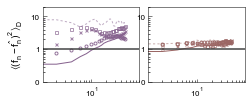

In [8]:
labels = [r'QKF(True $\Phi)$', r'QKF(AKF $\Phi$)', r'']
color = [COLOURDICT['QKF'], COLOURDICT['AKF']] # By algorithm
figstyl = ['-', 'o', 'x', 's', ':']  # By regime 


gs = gridspec.GridSpec(1, 2,
                       left=0.1, right=0.99, 
                       top=0.99, bottom=0.1, 
                       wspace=0.1, hspace=0.1)

fig = plt.figure(figsize=(cm2inch(8),cm2inch(3.)))
ax_0 = fig.add_subplot(gs[0, 0])
ax_1 = fig.add_subplot(gs[0, 1])



for idx_algo in xrange(2):
    
    for idx_q_regime in xrange(len(q_regime)):
        
        alpha_gradient = 1.0 - 0.12*idx_q_regime
        
        vars()['ax_'+str(idx_algo)].plot(np.arange(0, n_predict, 2), 
                                   norm_z_states_[idx_q_regime][idx_algo][n_train : num : 2], 
                                   figstyl[idx_q_regime], 
                                   label=labels[idx_algo], 
                                   c=color[idx_algo],
                                   markeredgecolor=color[idx_algo],
                                   alpha=alpha_gradient,
                                   markerfacecolor="None", ms=3,lw=1)
        
    vars()['ax_'+str(idx_algo)].margins(0.2)
    vars()['ax_'+str(idx_algo)].set_yscale('log')
    vars()['ax_'+str(idx_algo)].set_xscale('log')
    vars()['ax_'+str(idx_algo)].axhline(y=1.0, c=COLOURDICT['TRUTH'])
    vars()['ax_'+str(idx_algo)].yaxis.set_major_formatter(FormatStrFormatter('%.0f'))
    #vars()['ax_'+str(idx_algo)].yaxis.set_minor_formatter(FormatStrFormatter('%.0f'))   
    vars()['ax_'+str(idx_algo)].tick_params(direction='in', which='both')
    vars()['ax_'+str(idx_algo)] = set_font_sizes(vars()['ax_'+str(idx_algo)], fsize, Fsize)
    vars()['ax_'+str(idx_algo)].yaxis.set_major_locator(ticker.LogLocator(base=10, numticks=2))
    vars()['ax_'+str(idx_algo)].set_ylim([0.1, 20])

ax_0.set_ylabel(r'$\langle (f_n -\hat{f_n})^2 \rangle_D$')

# ax_0.set_ylim([0.6,3.0])

fig.savefig(savefig+figname+'.svg', format='svg', dpi=400)
plt.show()